# Natural Language Processing with Disaster Tweets



## Description of the problem and data

In this exercise I'm going to build a model that predicts which Tweets are about real disasters and which ones are not, using the data from Kaggle competition:

https://www.kaggle.com/competitions/nlp-getting-started/overview

The available data is organized in two files; train and test, with the text of the Tweets and the classification: 1 when it is about a real disaster and 0 when is not.


As is require in this course, I created a GitHub repository  for this project:

https://github.com/edmon2017/Histopathologic-Cancer-Detection

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
import os

In [45]:
df = pd.read_csv("train.csv")

## Exploratory Data Analysis (EDA)

The first step is to review the data, in this step I'll perform the next tasks:
* Look if the are missing tweets.

* Analyze class imbalance

* Analyze the length of the Tweets

* Cleaning the data to reduce noise, I'll transfotm to lower-case, and strip punctuation/URLs.

In [46]:
print("Shape:", df.shape)
display(df.head())

Shape: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [47]:
print(df.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


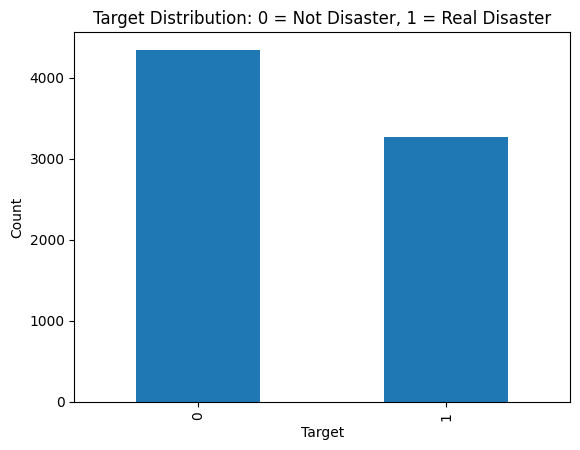

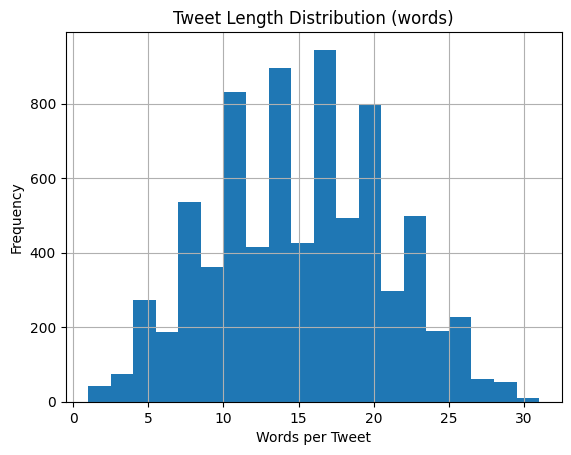

In [16]:
df['target'].value_counts().plot(kind='bar')
plt.title("Target Distribution: 0 = Not Disaster, 1 = Real Disaster")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

df['text_length'] = df['text'].fillna("").str.split().apply(len)
df['text_length'].hist(bins=20)
plt.title("Tweet Length Distribution (words)")
plt.xlabel("Words per Tweet")
plt.ylabel("Frequency")
plt.show()

In [17]:
def clean_text(s):
    s = s.lower()
    s = re.sub(r'http\S+','', s)        # remove URLs
    s = re.sub(r'[^a-z0-9\s]','', s)    # remove punctuation
    return s

df['clean_text'] = df['text'].fillna("").astype(str).apply(clean_text)

After the EDA, I found this main observations:

* There are 7613 recoard, the column called 'text' cotains the tweets and 'target' the classification

* Very few missing tweets.

* Class imbalance: typically ~60/40 split.

* Most tweets are under 30 words.

* Data was cleaned.

## Model Architecture
For this exercise I'm going to use a recurent neural network (RNN). This because Tweets are short sequences of tokens with word-order patterns, and the RNN can learn these sequential dependencies.

I'm going to use:

* Embedding layer (maps each token to a dense vector space; learned during training).

* Bidirectional LSTM and GRU (captures context from both left→right and right→left).

* Dropout (prevents over-fitting).

* Dense→Sigmoid (binary classification).


Before the model, the first step is to process the data, for that I'm going to use a Tokenizer, so it can be used as input for the model.

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [19]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(sequences, maxlen=50, padding='post', truncating='post')
y = df['target'].values

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val   = np.array(X_val)
y_val   = np.array(y_val)

In [21]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
            .shuffle(10_000).batch(128)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(128)

I'm going to create two models using different algoritmhs (LSTM and GRU), and compare which one has the best results

In [28]:
#Model builder functions
def build_rnn(rnn_type='lstm', vocab_size=10000, embed_dim=100, rnn_units=64, dropout=0.5):
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, input_length=50))
    if rnn_type == 'lstm':
        model.add(Bidirectional(LSTM(rnn_units)))
    else:
        model.add(Bidirectional(GRU(rnn_units)))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  run_eagerly=True,
                  metrics=['accuracy'])
    return model

In [29]:
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model_lstm = build_rnn('lstm')
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=10, batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[es]
)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5766 - loss: 0.6718 - val_accuracy: 0.7722 - val_loss: 0.5401
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8160 - loss: 0.4456 - val_accuracy: 0.7991 - val_loss: 0.4441
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8845 - loss: 0.2978 - val_accuracy: 0.7899 - val_loss: 0.4897
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9260 - loss: 0.2110 - val_accuracy: 0.7958 - val_loss: 0.5090


In [31]:
model_gru = build_rnn('gru')
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=10, batch_size=128,
    validation_data=(X_val, y_val),
    callbacks=[es]
)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.5802 - loss: 0.6716 - val_accuracy: 0.7741 - val_loss: 0.4997
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8064 - loss: 0.4349 - val_accuracy: 0.7932 - val_loss: 0.4449
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.8871 - loss: 0.2844 - val_accuracy: 0.7886 - val_loss: 0.4930
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9160 - loss: 0.2194 - val_accuracy: 0.7879 - val_loss: 0.5195


## Results and Analysis
I this step, I'm going to compare the restuls and generate a plot to compare the prediction from both models

In [32]:
from sklearn.metrics import classification_report, roc_auc_score

# LSTM evaluation
proba_lstm = model_lstm.predict(X_val)
pred_lstm = (proba_lstm > 0.5).astype(int)
print("LSTM Report:\n", classification_report(y_val, pred_lstm))
print("LSTM AUC:", roc_auc_score(y_val, proba_lstm))

# GRU evaluation
proba_gru = model_gru.predict(X_val)
pred_gru = (proba_gru > 0.5).astype(int)
print("GRU Report:\n", classification_report(y_val, pred_gru))
print("GRU AUC:", roc_auc_score(y_val, proba_gru))

48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 371ms/step
LSTM Report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84       874
           1       0.84      0.65      0.73       649

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.81      0.80      0.79      1523

LSTM AUC: 0.8539391706304013
48/48 ━━━━━━━━━━━━━━━━━━━━ 29s 591ms/step
GRU Report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83       874
           1       0.80      0.68      0.74       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.78      1523
weighted avg       0.79      0.79      0.79      1523

GRU AUC: 0.8551838244368206


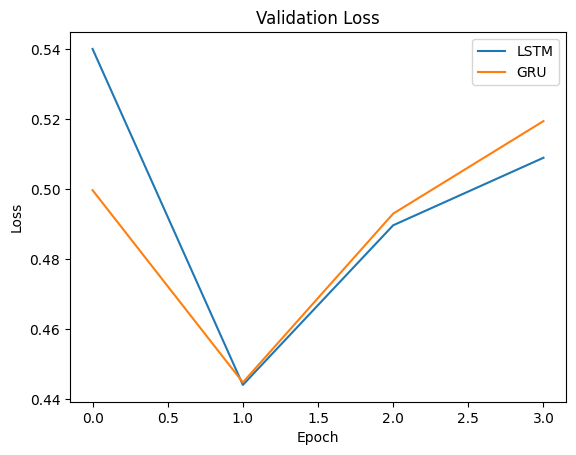

In [33]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_lstm.history['val_loss'], label='LSTM')
plt.plot(history_gru.history['val_loss'], label='GRU')
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The results are similar, the accuracy for the LSTM model is a little better but the difference is very small

## Hyperparameter tunning
For this step I'm going to analyze the effect of the size of the Embedding layer and the number of units of the bidirectional layer

In [34]:
# Very simple grid over embed_dim & rnn_units for LSTM
results = []
for units in [32, 64]:
    for ed in [50, 100]:
        m = build_rnn('lstm', embed_dim=ed, rnn_units=units)
        history = m.fit(
            X_train, y_train,
            epochs=5, batch_size=128,
            validation_data=(X_val, y_val),
            callbacks=[es],
            verbose=0
        )
        auc = roc_auc_score(y_val, m.predict(X_val))
        results.append({'units': units, 'embed_dim': ed, 'auc': auc})

import pandas as pd
print(pd.DataFrame(results))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 350ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 351ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step
   units  embed_dim       auc
0     32         50  0.855521
1     32        100  0.857052
2     64         50  0.854695
3     64        100  0.856710


TRhe best hyperparameters are 64 units and 100 dim embeddings.

## Test set
For the test dataset, I followed the same process:
* Loading and cleaning the data.
* Tokenize the data
* Make predictions

Next, data is exported as CSV file for Kaggle contest

In [41]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [42]:
df_test['clean_text'] = df_test['text'].fillna("").astype(str).apply(clean_text)
sequences_test = tokenizer.texts_to_sequences(df_test['clean_text'])
X_test_padded  = pad_sequences(sequences_test, maxlen=50, padding='post', truncating='post')

# Run the model prediction
prob_test = model_lstm.predict(X_test_padded, batch_size=128, verbose=1)
preds_test = (prob_test > 0.5).astype(int).reshape(-1)


26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 484ms/step


In [43]:
submission = pd.DataFrame({
    'id': df_test['id'],
    'target': preds_test
})

submission.to_csv('disaster_predictions.csv')

## Conclusions

In this exercise I create a model to classify dissarter tweets. In the process, the EDA and Cleaning revealed moderate class imbalance and short tweet lengths.

For the model I create a bidirectional RNN, in this case LSTM and GRU, had similar results.

Some key point are:

* The highest validation AUC was close to 0.86.

* The best hyperparameters are 64 units and 100 dim embeddings.

* Early stopping and dropout were useful to prevent over-fitting.

Results could be improved using a pretrained embeddings.

